# VGG-19

### Imports and Device Setup

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')


Using device: cuda


### Data Preprocessing and Augmentation

In [12]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
])


### Load CIFAR-100 Dataset

In [13]:
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)


### Define VGG-19 Model

In [14]:
cfg = {
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M',
          512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
}

def make_layers(cfg):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            layers += [conv, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

class VGG19(nn.Module):
    def __init__(self, num_classes=100):
        super(VGG19, self).__init__()
        self.features = make_layers(cfg['E'])
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


### Model Initialization, Loss Function, Optimizer

In [19]:
model = VGG19().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


### Training and Validation Loop

In [20]:
train_loss, val_loss = [], []
train_acc, val_acc = [], []

for epoch in range(150):
    model.train()
    running_loss = 0
    correct, total = 0, 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss.append(running_loss / len(trainloader))
    train_acc.append(100 * correct / total)

    model.eval()
    running_loss = 0
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss.append(running_loss / len(testloader))
    val_acc.append(100 * correct / total)

    print(f"Epoch {epoch+1}: Train Acc={train_acc[-1]:.2f}%, Val Acc={val_acc[-1]:.2f}%")


Epoch 1: Train Acc=2.38%, Val Acc=3.09%
Epoch 2: Train Acc=3.27%, Val Acc=3.93%
Epoch 3: Train Acc=3.60%, Val Acc=3.75%
Epoch 4: Train Acc=4.09%, Val Acc=4.51%
Epoch 5: Train Acc=4.93%, Val Acc=5.47%
Epoch 6: Train Acc=6.53%, Val Acc=7.75%
Epoch 7: Train Acc=9.15%, Val Acc=9.83%
Epoch 8: Train Acc=11.32%, Val Acc=14.75%
Epoch 9: Train Acc=13.54%, Val Acc=14.82%
Epoch 10: Train Acc=15.72%, Val Acc=18.41%
Epoch 11: Train Acc=17.55%, Val Acc=17.02%
Epoch 12: Train Acc=19.69%, Val Acc=18.58%
Epoch 13: Train Acc=21.53%, Val Acc=21.96%
Epoch 14: Train Acc=23.38%, Val Acc=22.92%
Epoch 15: Train Acc=25.30%, Val Acc=27.40%
Epoch 16: Train Acc=26.89%, Val Acc=28.98%
Epoch 17: Train Acc=28.58%, Val Acc=30.82%
Epoch 18: Train Acc=30.71%, Val Acc=29.46%
Epoch 19: Train Acc=32.71%, Val Acc=33.71%
Epoch 20: Train Acc=34.54%, Val Acc=34.49%
Epoch 21: Train Acc=36.51%, Val Acc=37.64%
Epoch 22: Train Acc=37.66%, Val Acc=35.59%
Epoch 23: Train Acc=39.65%, Val Acc=39.54%
Epoch 24: Train Acc=41.45%, Val Ac

### Plot Loss and Accuracy Curves

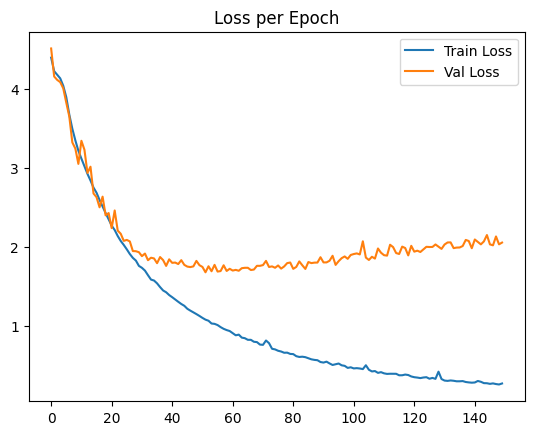

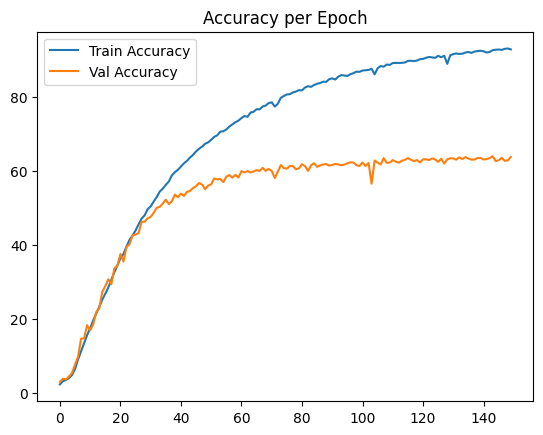

In [21]:
plt.figure()
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.title("Loss per Epoch")
plt.show()

plt.figure()
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.legend()
plt.title("Accuracy per Epoch")
plt.show()


### Visualize Convolutional Filters (Before & After Training)

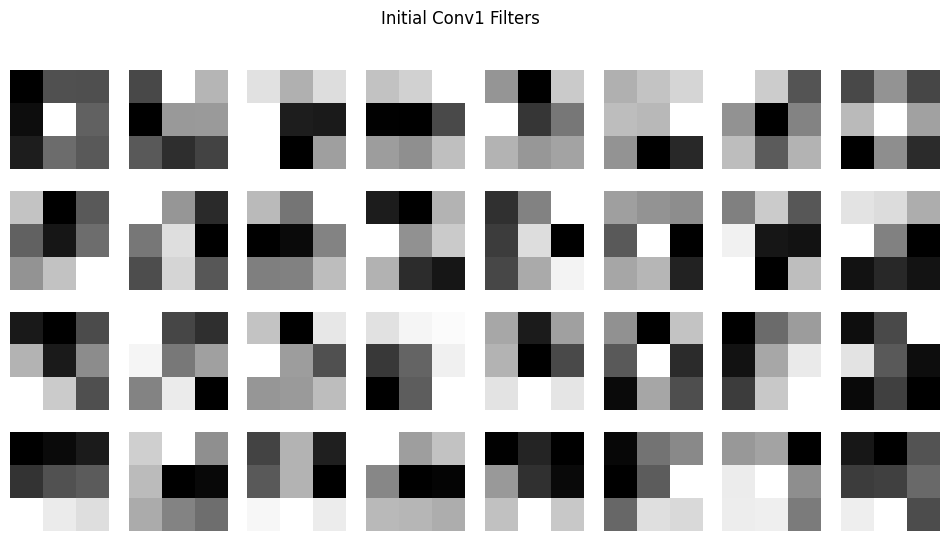

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001BFFF79EA70>
Traceback (most recent call last):
  File "c:\Users\House\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "c:\Users\House\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py", line 1621, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


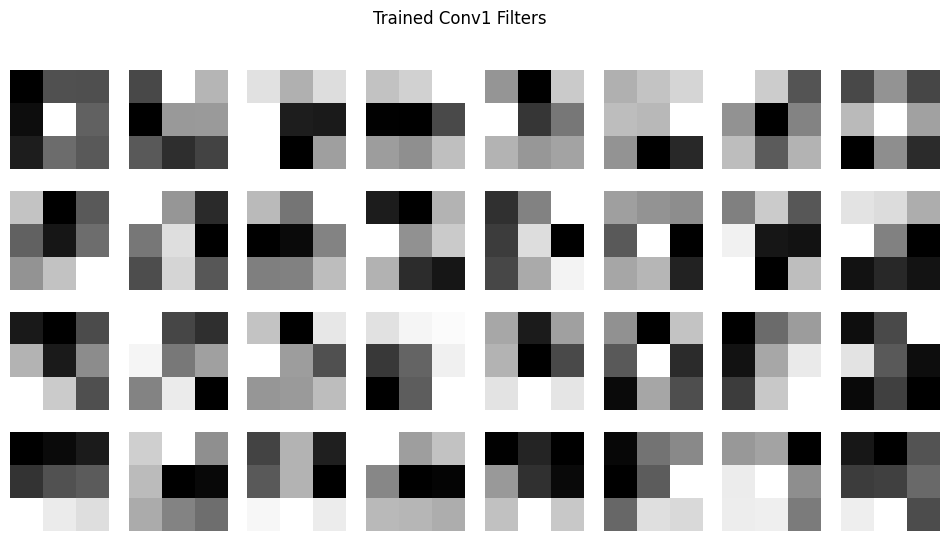

In [22]:
def visualize_filters(weights, title):
    weights = weights.cpu().detach().numpy()
    fig, axes = plt.subplots(4, 8, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        if i < weights.shape[0]:
            img = weights[i, 0]
            ax.imshow(img, cmap='gray')
            ax.axis('off')
    plt.suptitle(title)
    plt.show()

initial_weights = model.features[0].weight.clone()
visualize_filters(initial_weights, "Initial Conv1 Filters")
visualize_filters(model.features[0].weight, "Trained Conv1 Filters")


### Evaluate Model Performance on Test Set

In [23]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, output_dict=True)


### Evaluation Metrics and Summary Table

In [24]:
TP = np.diag(cm).sum()
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

metrics_table = pd.DataFrame({
    'Metric': ['True Positives', 'False Positives', 'False Negatives', 'True Negatives', 'Accuracy', 'F1-Score'],
    'Value': [
        TP,
        FP.sum(),
        FN.sum(),
        TN.sum(),
        accuracy_score(all_labels, all_preds),
        f1_score(all_labels, all_preds, average='macro')
    ]
})
print(metrics_table)


            Metric          Value
0   True Positives    6387.000000
1  False Positives    3613.000000
2  False Negatives    3613.000000
3   True Negatives  354074.000000
4         Accuracy       0.638700
5         F1-Score       0.640625
